In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/yolov5"

/content/drive/MyDrive/Colab Notebooks/yolov5


In [3]:
import torch
import numpy as np
import cv2
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords
from utils.plots import Annotator
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import os
import math

In [4]:
PED_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/yolov5/runs/train/exp47/weights/best.pt'
CROSS_MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/yolov5/runs/train/exp54/weights/best.pt'

TEST_VIDEO_PATH = '/content/drive/MyDrive/Colab Notebooks/test-video/'
TEST_VIDEO_SAVE_PATH = TEST_VIDEO_PATH + 'output/'

img_size = 640
conf_thres = 0.5
iou_thres = 0.45
max_det = 1000
classes = None
agnostic_nms = False

In [5]:
ped_device = torch.device('cpu')
print(ped_device)
ped_ckpt = torch.load(PED_MODEL_PATH, map_location = ped_device)
# print(ped_ckpt)
ped_model = ped_ckpt['ema' if ped_ckpt.get('cma') else 'model'].float().fuse().eval()
# print(type(ped_model))
ped_class_names = ['보행자', '차량']
ped_stride = int(ped_model.stride.max())
# print(ped_stride)
ped_colors = ((50, 50, 50), (255, 0, 0))

cpu


Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients


In [6]:
cross_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(cross_device)
cross_ckpt = torch.load(CROSS_MODEL_PATH, map_location = cross_device)
cross_model = cross_ckpt['ema' if cross_ckpt.get('cma') else 'model'].float().fuse().eval()
cross_class_names = ['보행자', '차량', '횡단보도', '빨간불', '초록불']
cross_stride = int(cross_model.stride.max())
cross_colors = ((50, 50, 50), (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 255, 0))

cuda:0


Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients


In [ ]:
img = cv2.imread(os.path.join(TEST_VIDEO_PATH, 'test1.png') , cv2.IMREAD_COLOR)

H, W, _ = img.shape
print(H,W,sep=',')

cx1, cy1, cx2, cy2 = 0, 0, 0, 0

1664,2784


In [ ]:
def detect(annotator, img, stride, device, model, class_names, colors):
    global cx1, cy1, cx2, cy2

    H, W, _ = img.shape

    img_input = letterbox(img, img_size, stride = stride)[0]
    img_input = img_input.transpose((2, 0, 1))[::-1]
    img_input = np.ascontiguousarray(img_input)
    img_input = torch.from_numpy(img_input).to(device)
    img_input = img_input.float()
    img_input /= 255.
    img_input = img_input.unsqueeze(0)

    pred = model(img_input, augment = False, visualize = False)

    print("len(pred): ", len(pred))
    print("len(pred[0]): ", len(pred[0]))
    print("len(pred[1]): ", len(pred[1]))

    print("type(pred[0]): ", type(pred[0]))
    print("type(pred[1]): ", type(pred[1]))

    print("pred[1][0].shape: ", pred[1][0].shape)
    print("pred[1][1].shape: ", pred[1][1].shape)
    print("pred[1][2].shape: ", pred[1][2].shape)

    print("type(pred[1][0]): ", type(pred[1][0]))
    print("type(pred[1][1]): ", type(pred[1][1]))
    print("type(pred[1][2]): ", type(pred[1][2]))

    pred = pred[0]
 
    # print(non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det = max_det))
    
    print("pred[0]: ", pred)
    print("pred[0].shape: ", pred.shape)
    print("pred[0].shape[0]: ", pred.shape[0])
    print("pred[0].shape[1]: ", pred.shape[1])
    print("pred[0].shape[2]: ", pred.shape[2])
  
    a = [torch.zeros((0, 6), device=ped_device)] * pred.shape[0]
    print("a: ", a)

    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det = max_det)[0]

    print('\n')

    pred = pred.cpu().numpy()

    pred[:, :4] = scale_coords(img_input.shape[2:], pred[:, :4], img.shape).round()

    for p in pred:
        class_name = class_names[int(p[5])]
        x1, y1, x2, y2 = p[:4]
        
        if int(p[5]) == 2:
            print(x1, y1, x2, y2, sep=',')
            cx1, cy1, cx2, cy2 = x1, y1, x2, y2
        annotator.box_label([x1, y1, x2, y2], '%s %d' % (class_name, float(p[4]) * 100), color=colors[int(p[5])])

In [ ]:
annotator = Annotator(img.copy(), line_width = 3, example = '한글', font = 'data/malgun.ttf')

detect(annotator, img, ped_stride, ped_device, ped_model, ped_class_names, ped_colors)
detect(annotator, img, cross_stride, cross_device, cross_model, cross_class_names, cross_colors)

result_img = annotator.result()

print(cx1, cy1, cx2, cy2, sep=', ')

# cv2_imshow(result_img)

len(pred) 2
len(pred[0]) 1
len(pred[1]) 3
type(pred[0]):  <class 'torch.Tensor'>
type(pred[1]):  <class 'list'>
pred[1][0].shape:  torch.Size([1, 3, 48, 80, 10])
pred[1][1].shape:  torch.Size([1, 3, 24, 40, 10])
pred[1][2].shape:  torch.Size([1, 3, 12, 20, 10])
type(pred[1][0]):  <class 'torch.Tensor'>
type(pred[1][1]):  <class 'torch.Tensor'>
type(pred[1][2]):  <class 'torch.Tensor'>
pred[0]:  tensor([[[5.22452e+00, 6.87714e+00, 8.80715e+00,  ..., 6.78501e-03, 8.15730e-03, 5.73605e-03],
         [1.21886e+01, 7.60551e+00, 1.98208e+01,  ..., 8.44497e-03, 1.18763e-02, 1.02831e-02],
         [1.59225e+01, 5.77033e+00, 2.98711e+01,  ..., 7.82574e-03, 1.01441e-02, 7.15296e-03],
         ...,
         [5.60499e+02, 3.60225e+02, 2.29105e+02,  ..., 2.81273e-01, 3.34782e-01, 3.39324e-01],
         [5.90100e+02, 3.60270e+02, 1.94478e+02,  ..., 2.60726e-01, 3.22911e-01, 3.20024e-01],
         [6.20817e+02, 3.57476e+02, 1.64001e+02,  ..., 2.66821e-01, 3.44336e-01, 3.16069e-01]]])
pred[0].shape:  

### opencv 

In [ ]:
def fixColor(img):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### set ROI

In [ ]:
cut_img = img[int(cy1):int(cy2), int(cx1):int(cx2)].copy()

#### hsv method

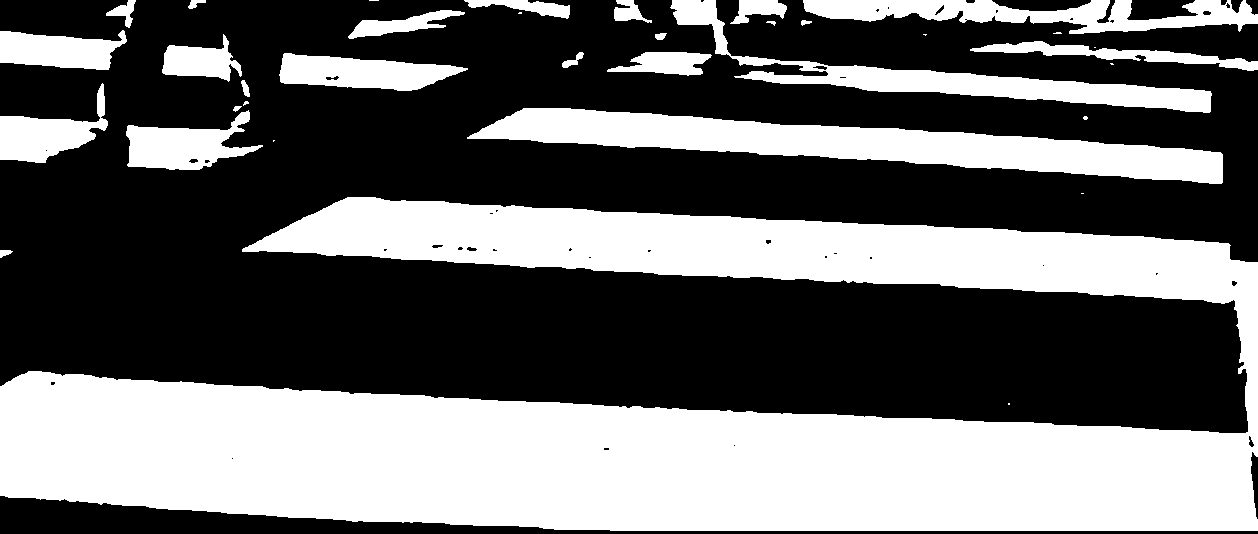

In [ ]:
hsv_img = cv2.cvtColor(cut_img, cv2.COLOR_BGR2HSV)

# cv2_imshow(hsv_img)

hsv_img = cv2.GaussianBlur(hsv_img, (5, 5), 0)
lower_white = (0, 0, 200)
upper_white = (180, 255, 255)
hsv_img = cv2.inRange(hsv_img, lower_white, upper_white)

cv2_imshow(hsv_img)

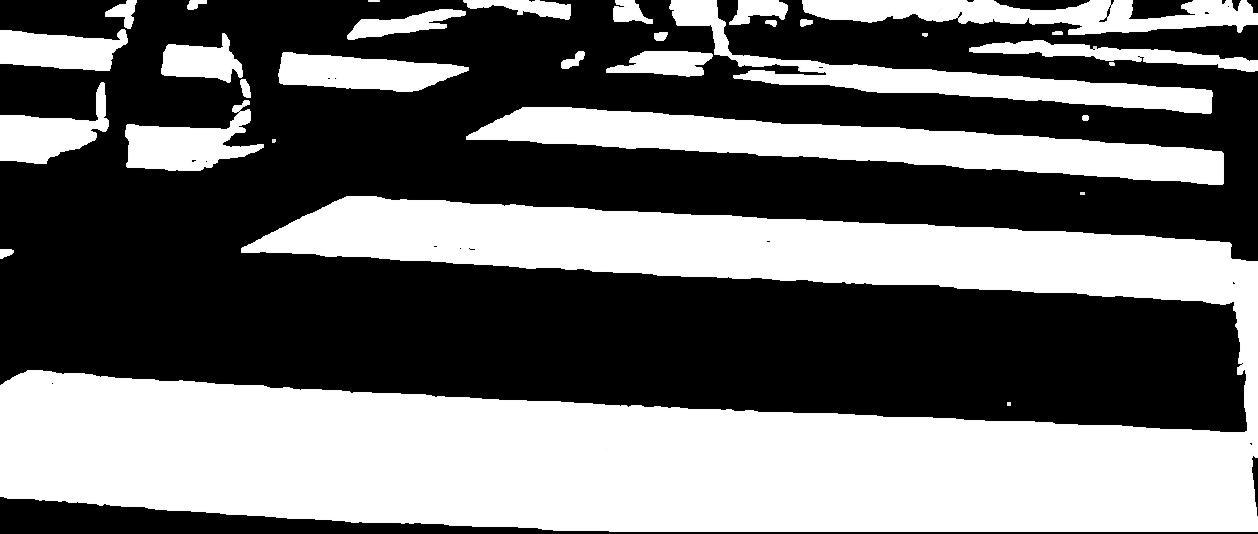

In [ ]:
img_filter = cv2.bilateralFilter(hsv_img, 5, 100, 100)
kernel = np.ones((3, 3), np.uint8)
img_dilate = cv2.dilate(img_filter, kernel)

cv2_imshow(img_dilate)

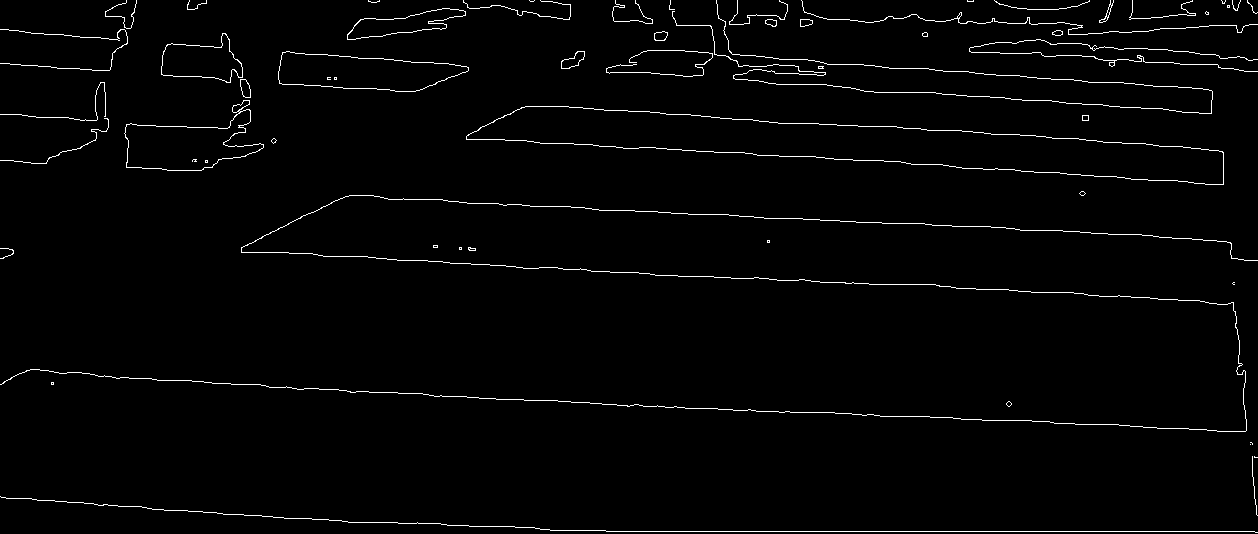

In [ ]:
canny = cv2.Canny(img_dilate, 150, 270)
line_result = cv2.cvtColor(canny, cv2.COLOR_GRAY2BGR)
cv2_imshow(line_result)

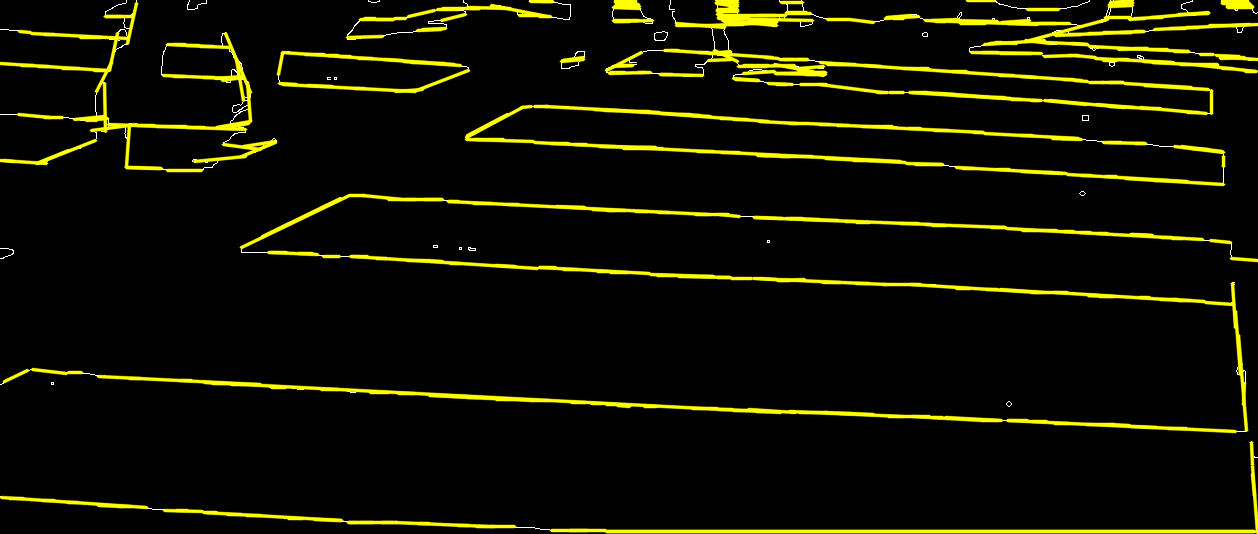

In [ ]:
lines = cv2.HoughLinesP(canny, 1, math.pi / 180, threshold = 20, lines = None, minLineLength = 20, maxLineGap = 20)
for line in range(0, len(lines)):
  l = lines[line][0]
  cv2.line(line_result, (l[0], l[1]), (l[2], l[3]), (0, 255, 255), 2, cv2.LINE_AA)

cv2_imshow(line_result)

#### houghlinesp

In [ ]:
gray = cv2.cvtColor(cut_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

canny = cv2.Canny(blurred, 30, 300)

cv2_imshow(canny)

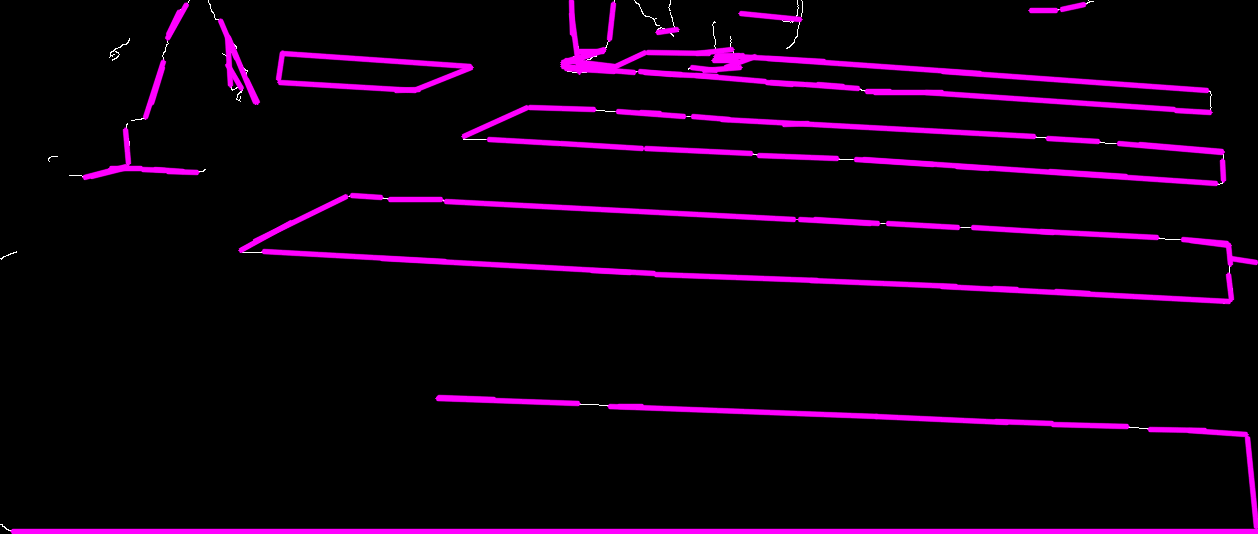

In [ ]:
lines = cv2.HoughLinesP(canny, 1, math.pi / 180, threshold = 20, lines = None, minLineLength = 20, maxLineGap = 20)
edges = fixColor(canny)

if lines is not None:
    for line in range(0, len(lines)):
        l = lines[line][0]
        cv2.line(edges, (l[0], l[1]), (l[2], l[3]), (255, 0, 255), 3, cv2.LINE_AA)

cv2_imshow(edges)

#### findconours

115.0, 984.0, 1373.0, 1518.0


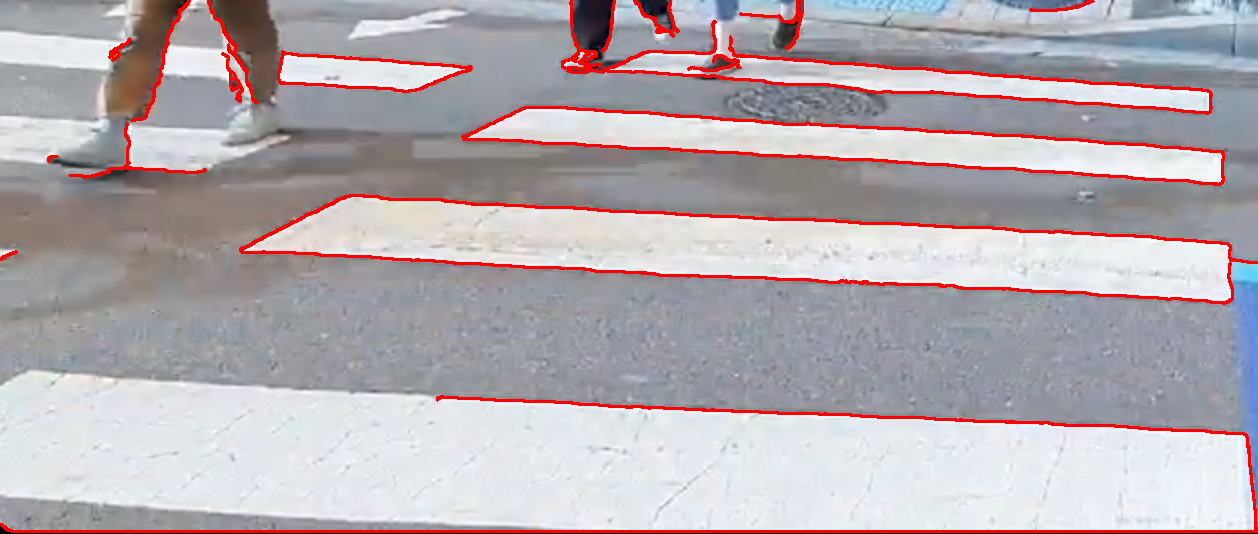

In [ ]:
(contours, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result_img = cut_img.copy()
cv2.drawContours(cut_img, contours, -1, (255, 0, 0), 2)
print(cx1, cy1, cx2, cy2, sep=', ')

cv2_imshow(fixColor(cut_img))